In [2]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import os
os.environ ["KMP_DUPLICATE_LIB_OK"] ="TRUE"

In [3]:
max_degree = 20 #最高阶数
n_train, n_test = 100, 100 # 训练数据集和测试数据集大小
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5,1.2,-3.4,5.6])

features = np.random.normal(size = (n_train + n_test,1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i+1)

labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)





In [4]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.6444],
         [-0.4478]]),
 tensor([[ 1.0000e+00,  6.4439e-01,  2.0762e-01,  4.4595e-02,  7.1842e-03,
           9.2588e-04,  9.9438e-05,  9.1538e-06,  7.3732e-07,  5.2791e-08,
           3.4018e-09,  1.9928e-10,  1.0701e-11,  5.3044e-13,  2.4415e-14,
           1.0488e-15,  4.2241e-17,  1.6012e-18,  5.7320e-20,  1.9440e-21],
         [ 1.0000e+00, -4.4777e-01,  1.0025e-01, -1.4963e-02,  1.6750e-03,
          -1.5001e-04,  1.1195e-05, -7.1612e-07,  4.0083e-08, -1.9942e-09,
           8.9296e-11, -3.6350e-12,  1.3564e-13, -4.6719e-15,  1.4943e-16,
          -4.4606e-18,  1.2483e-19, -3.2881e-21,  8.1796e-23, -1.9277e-24]]),
 tensor([5.4679, 4.0560]))

In [5]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric.data[0] / metric.data[1]

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='mean')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.003817   1.2403337 -3.3822503  5.5151653]]


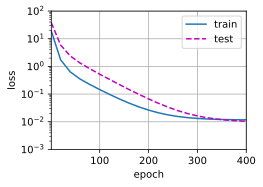

In [7]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.6017773 3.610246 ]]


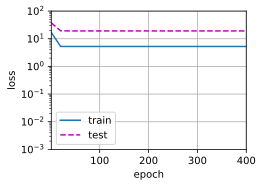

In [8]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.989506    1.2884293  -3.2998235   5.149591   -0.27271512  1.3610786
  -0.01577276  0.2083969   0.14125215  0.01667155 -0.1269663   0.18180878
   0.1888088   0.11296169  0.0622016  -0.07998386  0.17973137 -0.17781857
  -0.11779319 -0.17682508]]


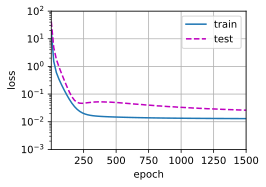

In [9]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)